## Image processing for CT scans

### example by Xiao Luo, luoxiao@utexas.edu, https://github.com/playbar12641/

If you have the mask file, and want to calculate local saturations, run this.

load library and masking files

In [3]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# my library
from CTprocessinglib import read_pile  # read pile file and has option of filter data
from CTprocessinglib import pick_circle # get circle centers for scans
from CTprocessinglib import create_circular_mask # a disc-shape mask
from CTprocessinglib import create_square_mask # a square-shape mask 
from CTprocessinglib import create_mask_matrix # a matrix contains all crossectional mask, circle or square
from CTprocessinglib import crop_scan # crop out the scan based on the circular and square mask

# specify working directory
path=os.path.expanduser('~\\Box Sync\\CT result\\CT_workflow')  
os.chdir(path) # set the working directory

square_mask = np.load('square_mask.npy').astype(bool)
circular_mask = np.load('circular_mask.npy').astype(bool)

#### Step 1, load scan files and corp the scans
if you have the masking files, for any new scans, just do read_pile and crop_scan to process the files

In [5]:
# I for air, II for oil baselines
k = 4 # filter size
I = read_pile(path,'pile_LX_airBL_072019_01',k) # air baseline scan
airbase = crop_scan(I.astype(float), circular_mask, square_mask) 

II = read_pile(path,'pile_LX_oilBL_072019_01',k) # oil baseline scan
oilbase = crop_scan(II.astype(float), circular_mask, square_mask) 

new_scan = read_pile(path,'pile_LX_oilFb_072119_04',k) # actual scan need to be calculated
scan = crop_scan(new_scan.astype(float), circular_mask, square_mask) 

#### Step 2, calculate porosity and local saturations

$\phi=\frac{\Omega^{b,air}-\Omega^{b,II}}{\Omega^{air}-\Omega^{II}}$

$S^{II}=1-\frac{\Omega^{bulk}-\Omega^{b,II}}{\phi  (\Omega^I-\Omega^{II})}$


In [6]:
# calculate porosity
omega_air = -1000 # CT attenuation for air at std
omega_I = -953 # CT attenuation of gas at exp P,T
omega_II = -325 # CT attenuation of oil at exp P,T
phi = (airbase - oilbase) / (omega_air - omega_II)

# calculate oil saturation S^II
so = 1-np.divide((scan-oilbase)/(omega_I - omega_II), phi)

#### Step 3, plot saturation

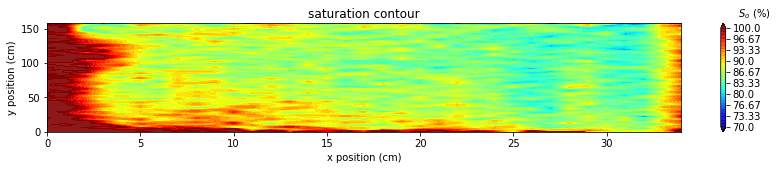

In [9]:
Z=so # pass saturation to a generic variable Z

core_width = 2
aspect_ratio = 7.1
zmin = 70; zmax = 100

p_slice = np.nanmean(Z, axis=1) #axis=0 row-wise average, axis=1 column-wise average 
[n1,n2]=p_slice.shape
x = np.arange(n1)
y = np.arange(n2)
X, Y = np.meshgrid(y, x)

#zmin = np.min(p_slice)*100; zmax = np.max(p_slice)*100

#zmin=10;zmax=25;nl=4;
c_ticks = np.linspace(zmin, zmax, 10) # pre-specify colorbar ticks
c_ticks = np.round(c_ticks,2)

#fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,2))   
fig, ax1 = plt.subplots(1,1,figsize=(core_width*aspect_ratio,core_width ))  
cf1 = ax1.contourf(X, Y, p_slice*100, np.linspace(zmin, zmax, 30), cmap='jet',alpha=0.9,corner_mask=True,extend='both') # contour plot with 5 levels
cb1 = fig.colorbar(cf1, ax=ax1)
cb1.set_ticks(c_ticks)
cb1.set_ticklabels(c_ticks)
cb1.set_label('$S_o$ (%)', labelpad=-7, y=1.15, rotation=0)
ax1.set_xlabel('x position (cm)');ax1.set_ylabel('y position (cm)');ax1.set_title('saturation contour'); # specify labels and titles#plt.colorbar()

# save figures
plt.draw()
fig.savefig('fig1',bbox_inches='tight')